In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy import stats

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

from transformers import BertTokenizer, BertModel
from tqdm import tqdm

import torch
import torch.nn as nn

pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 300)

In [2]:
train_df = pd.read_csv('clean_data.csv')
val_df = pd.read_csv('clean_val.csv')
test_df = pd.read_csv('clean_test.csv')

In [3]:
train_df.dropna(inplace = True)

In [4]:
with open("numerical.txt", "r", encoding="utf-8") as file:
    numeric_features = [line.strip() for line in file.readlines()]
    
with open("cat.txt", "r", encoding="utf-8") as file:
    cat_features = [line.strip() for line in file.readlines()]
    
with open("text.txt", "r", encoding="utf-8") as file:
    text_features = [line.strip() for line in file.readlines()]

In [5]:
print('Total number of Numerical Features and one target:', len(numeric_features))
print('Total number of Categorical Features:',len(cat_features))
print('Total number of Text Features:',len(text_features))

Total number of Numerical Features and one target: 9
Total number of Categorical Features: 70
Total number of Text Features: 2


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
model = BertModel.from_pretrained('bert-base-multilingual-cased')
model.to(device)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(119547, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
         

In [7]:
class BoxCoxTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.lambdas_ = {}

    def fit(self, X, y=None):
        X = X.copy()
        for column in X.columns:
            if any(X[column] <= 0):
                X[column] = X[column] + abs(X[column].min()) + 1
            _, lambda_optimal = stats.boxcox(X[column])
            self.lambdas_[column] = lambda_optimal
        return self

    def transform(self, X):
        X = X.copy()
        for column, lambda_optimal in self.lambdas_.items():
            if any(X[column] <= 0):
                X[column] = X[column] + abs(X[column].min()) + 1
            X[column] = stats.boxcox(X[column], lmbda=lambda_optimal)
        return X

def get_bert_embeddings(text_series, batch_size):
    embeddings = []
    model.eval()  
    
    for i in range(0, len(text_series), batch_size):
        batch_texts = text_series[i:i + batch_size]
        
        if not batch_texts: 
            continue
        
        inputs = tokenizer(batch_texts, return_tensors='pt', truncation=True, padding=True, max_length=128)
        inputs = {key: value.to(device) for key, value in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)
            batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
            embeddings.append(batch_embeddings)
    
    if embeddings:
        return np.vstack(embeddings)
    else:
        return np.array([])
    
def concat(df, text_features, batch_size, pooling, is_train = False):

    embeddings_list = []

    for feature in text_features:
        print(feature)
        text_embeddings = get_bert_embeddings(df[feature].tolist(), batch_size)

        if pooling == 'max':
            text_embeddings = np.max(text_embeddings, axis=1)  
        elif pooling == 'mean':
            text_embeddings = np.mean(text_embeddings, axis=1)  

        if text_embeddings.ndim == 1:
            text_embeddings = text_embeddings.reshape(-1, 1)
        df[feature + '_embedding'] = text_embeddings
        embeddings_list.append(text_embeddings)
        
    if is_train:
        transformed_features = preprocessor.fit_transform(df).toarray()
    else:
        transformed_features = preprocessor.transform(df).toarray()

    combined_features = np.concatenate(embeddings_list + [transformed_features], axis=1)

    return combined_features

In [8]:
numeric_transformer = Pipeline([
    ('boxcox', BoxCoxTransformer()),
    ('scaler', StandardScaler())
])


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
    ]
)

In [9]:
train_combined_features = concat(train_df, text_features, batch_size = 32, pooling = 'max', is_train = True)
val_combined_features = concat(val_df, text_features, batch_size = 32, pooling = 'max', is_train = False)
test_combined_features = concat(test_df, text_features, batch_size = 32, pooling = 'max', is_train = False)

summary
host_about
summary
host_about
summary
host_about


In [10]:
train_df['host_about_embedding']

0        1.816333
1        1.816333
2        3.398387
3        1.816333
4        3.415488
           ...   
17956    2.504780
17957    2.928672
17958    2.948318
17959    1.816333
17960    3.079402
Name: host_about_embedding, Length: 17941, dtype: float32

In [11]:
train_y = train_df['price']
val_y = val_df['price']
test_y = test_df['price']

In [12]:
from tqdm import tqdm

def rmse(y, y_predict):
    mse = mean_squared_error(y, y_predict)
    return math.sqrt(mse)

def evaluate_models(model):
    results = []

    for name, model in tqdm(model, desc="Evaluating Models"):
        
        model.fit(train_combined_features, train_y)
        
        val_predict = model.predict(val_combined_features)
        
        val_mae = mean_absolute_error(val_y, val_predict)
        val_rmse = rmse(val_y, val_predict)
        
        
        test_predict = model.predict(test_combined_features)
        test_mae = mean_absolute_error(test_y, test_predict)
        test_rmse = rmse(test_y, test_predict)
       
        results.append({
            'model': name,
            'val_mae': val_mae,
            'val_rmse': val_rmse,
            'test_mae': test_mae,
            'test_rmse': test_rmse,
        })
    
    return results

In [13]:
xgb = XGBRegressor()
lgm = LGBMRegressor()
cat = CatBoostRegressor()

models = [('xgb', xgb), ('lgm', lgm),('cat', cat)]

In [14]:
res = evaluate_models(models)

Evaluating Models:  67%|███████████████████████████████████████████▎                     | 2/3 [00:05<00:02,  2.47s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003737 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1792
[LightGBM] [Info] Number of data points in the train set: 17941, number of used features: 304
[LightGBM] [Info] Start training from score 134.868792
Learning rate set to 0.064608
0:	learn: 98.9517255	total: 162ms	remaining: 2m 42s
1:	learn: 96.4784396	total: 171ms	remaining: 1m 25s
2:	learn: 94.2015129	total: 181ms	remaining: 1m
3:	learn: 92.0712775	total: 190ms	remaining: 47.2s
4:	learn: 90.2401248	total: 199ms	remaining: 39.6s
5:	learn: 88.5070122	total: 208ms	remaining: 34.4s
6:	learn: 86.8610311	total: 217ms	remaining: 30.8s
7:	learn: 85.4052922	total: 226ms	remaining: 28s
8:	learn: 84.1163554	total: 235ms	remaining: 25.9s
9:	learn: 82.9095205	total: 245ms	remaining: 24.2s
10:	learn: 81.9042603	total: 253ms	remaining: 22.8s
11

Evaluating Models: 100%|█████████████████████████████████████████████████████████████████| 3/3 [00:20<00:00,  6.93s/it]


In [15]:
res_df = pd.DataFrame(res)
res_df.sort_values(by = 'test_mae')

,model,val_mae,val_rmse,test_mae,test_rmse
2,cat,49.142823,275.103588,45.095277,134.048885
0,xgb,49.699992,274.635847,45.723235,134.225901
1,lgm,49.435790,274.858869,45.862264,137.285951


In [16]:
features = numeric_features + cat_features + ['summary_embedding'] + ['host_about_embedding']

In [17]:
def get_feature_names_from_column_transformer(column_transformer):
    feature_names = []
    for name, transformer, columns in column_transformer.transformers_:
        if transformer == "drop":
            continue
        elif transformer == "passthrough":
            feature_names.extend(columns if isinstance(columns, list) else [columns])
        else:
            try:
                feature_names.extend(transformer.get_feature_names_out(columns))
            except AttributeError:
                feature_names.extend(columns if isinstance(columns, list) else [columns])
    return feature_names

In [18]:
import optuna

def objective(trial):
    
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.03)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    n_estimators = trial.suggest_int('n_estimators', 1000, 2000)
    subsample = trial.suggest_float('subsample', 0.6, 1.0)
    alpha =  trial.suggest_loguniform('alpha', 1e-8, 10.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.4, 1.0)
   
    model = XGBRegressor(
                learning_rate=learning_rate,
                max_depth=max_depth,
                n_estimators=n_estimators,
                subsample=subsample,
                alpha = alpha,
                colsample_bytree = colsample_bytree,
                random_state=42
            )
    
    model.fit(train_combined_features, train_y)
  
    val_predict = model.predict(val_combined_features)

    val_mae = mean_absolute_error(val_y, val_predict)
    val_rmse = rmse(val_y, val_predict)
    
    return val_mae

In [19]:
study3 = optuna.create_study(direction='minimize')
study3.optimize(objective, n_trials=50) 

[I 2024-11-22 16:04:12,629] A new study created in memory with name: no-name-1841ce9c-69a8-489a-a579-cb86516d4698
[I 2024-11-22 16:05:20,397] Trial 0 finished with value: 47.64408335291667 and parameters: {'learning_rate': 0.02832225810897685, 'max_depth': 7, 'n_estimators': 1614, 'subsample': 0.6697166572772184, 'alpha': 1.2199334950243567e-06, 'colsample_bytree': 0.5979194181909882}. Best is trial 0 with value: 47.64408335291667.
[I 2024-11-22 16:06:44,345] Trial 1 finished with value: 47.807001950806495 and parameters: {'learning_rate': 0.020896343790299365, 'max_depth': 6, 'n_estimators': 1979, 'subsample': 0.8745746120647686, 'alpha': 1.7397035563873737, 'colsample_bytree': 0.9897314997719238}. Best is trial 0 with value: 47.64408335291667.
[I 2024-11-22 16:07:33,996] Trial 2 finished with value: 47.00144061033101 and parameters: {'learning_rate': 0.02340850872462604, 'max_depth': 10, 'n_estimators': 1483, 'subsample': 0.8742048173183766, 'alpha': 5.897898412399192, 'colsample_byt

In [20]:
xgb_best_param = study3.best_trial.params
print("Best trial for XGBRegressor:")
print(study3.best_trial.params)
print("Best Validation MAE:", study3.best_value)

Best trial for XGBRegressor:
{'learning_rate': 0.02624727972070943, 'max_depth': 9, 'n_estimators': 1878, 'subsample': 0.8577067678951604, 'alpha': 0.07537790816320947, 'colsample_bytree': 0.5903186109207563}
Best Validation MAE: 46.89238643104143


In [21]:
best_xgb = XGBRegressor(**xgb_best_param)
best_models = [('xgb', best_xgb)]

In [22]:
res = evaluate_models(best_models)

Evaluating Models: 100%|█████████████████████████████████████████████████████████████████| 1/1 [01:20<00:00, 80.86s/it]


In [23]:
res_df = pd.DataFrame(res)
res_df.sort_values(by = 'test_mae')

,model,val_mae,val_rmse,test_mae,test_rmse
0,xgb,47.204364,274.031098,43.65225,136.034964


In [24]:


preprocessor.fit(train_df[features])

final_feature_names = get_feature_names_from_column_transformer(preprocessor)


model = XGBRegressor(**xgb_best_param)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regression', model)
])


pipeline.fit(train_df[features], train_y)

xgb_model = pipeline.named_steps['regression']

importances = xgb_model.feature_importances_


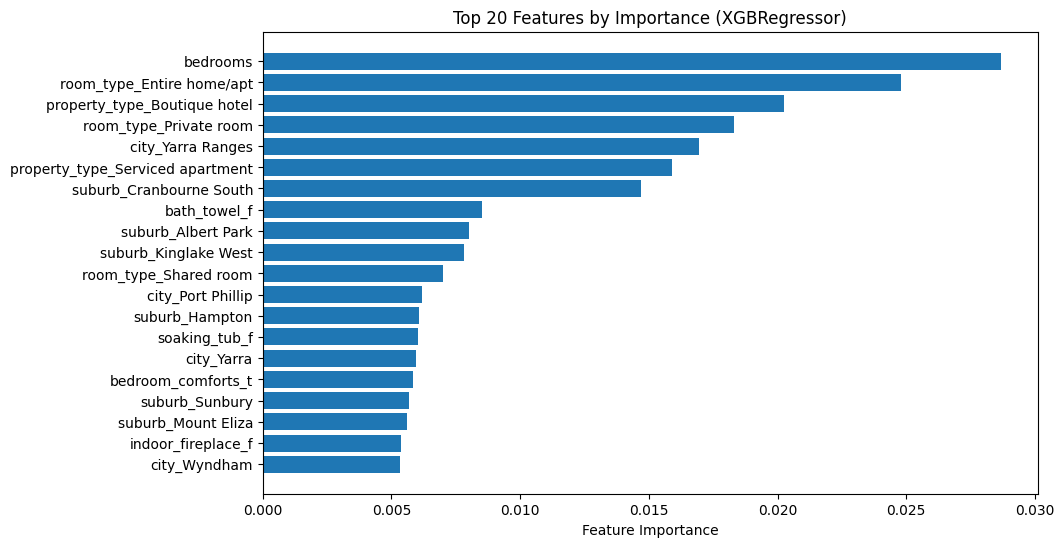

In [25]:
feature_importance_df = pd.DataFrame({
    'Feature': final_feature_names,
    'Importance': importances
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'][:20], feature_importance_df['Importance'][:20])
plt.xlabel("Feature Importance")
plt.gca().invert_yaxis()
plt.title("Top 20 Features by Importance (XGBRegressor)")
plt.show()